# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
print(pd.__version__)  # Hauria de mostrar la versió (ex: '2.1.3')

2.1.4


In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install --upgrade pandas google-cloud-bigquery

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.
pycaret 3.3.2 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import db_dtypes
print(db_dtypes.__version__)  # Hauria de mostrar la versió (ex: 1.2.0)


1.4.2


In [29]:
query = """
SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  a.intime,
  a.outtime,
  i.icd_code,
  d.icd_version,
  d.long_title,
  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,
  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.temperature,
  vitals.spo2,
  readmit.stay_id AS readmitted_stay
FROM
  `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN
  `ogi-uci-i61.mimiciv_hosp.patients` p
  ON a.subject_id = p.subject_id
JOIN
  `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  ON a.hadm_id = i.hadm_id
JOIN
  `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
  ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
LEFT JOIN (
  -- Select first GCS per stay
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM
    `ogi-uci-i61.mimiciv_derived.gcs`
) s
  ON a.stay_id = s.stay_id AND s.rn = 1
LEFT JOIN (
  -- Select first vitals per stay
  SELECT
    stay_id,
    heart_rate,
    mbp,
    resp_rate,
    temperature,
    spo2,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM
    `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals
  ON a.stay_id = vitals.stay_id AND vitals.rn = 1
LEFT JOIN (
  -- Identify next stay as readmission
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM
    `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN
    `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id
    AND a2.intime > a1.outtime
  GROUP BY
    a1.subject_id, a1.stay_id
) readmit
  ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id
WHERE
  LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
"""
df = client.query(query).to_dataframe()

df

,subject_id,hadm_id,stay_id,gender,intime,outtime,icd_code,icd_version,long_title,gcs_verbal,gcs_motor,gcs_eyes,heart_rate,mbp,resp_rate,temperature,spo2,readmitted_stay
0,10763729,25978404,36052003,M,2181-11-22 00:59:00,2181-12-07 17:27:23,431,9,Intracerebral hemorrhage,0.0,1.0,1.0,NaN,98.0,30.0,None,100.0,36052003
1,10763729,25978404,36434459,M,2181-12-09 01:21:42,2181-12-12 16:58:04,431,9,Intracerebral hemorrhage,4.0,6.0,4.0,NaN,90.0,NaN,None,NaN,<NA>
2,14306582,20415671,36446573,M,2158-12-01 07:36:00,2158-12-17 21:58:12,431,9,Intracerebral hemorrhage,0.0,5.0,2.0,NaN,NaN,NaN,None,NaN,<NA>
3,10173219,22913226,32333688,M,2153-11-24 17:45:48,2154-01-12 15:57:12,I69120,10,Aphasia following nontraumatic intracerebral h...,0.0,5.0,2.0,59.0,NaN,14.0,36.890000000,90.0,<NA>
4,10208612,26337634,37520781,M,2183-11-08 14:10:00,2183-11-09 13:06:17,I69122,10,Dysarthria following nontraumatic intracerebra...,1.0,4.0,1.0,69.0,NaN,15.0,None,92.0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,11441946,23476544,32310637,M,2204-06-27 18:00:00,2204-07-17 14:15:10,I69120,10,Aphasia following nontraumatic intracerebral h...,0.0,6.0,4.0,NaN,NaN,NaN,None,99.0,<NA>
4156,13224789,25046035,35073158,M,2115-02-07 06:53:00,2115-02-08 21:22:08,I69198,10,Other sequelae of nontraumatic intracerebral h...,5.0,6.0,4.0,75.0,NaN,16.0,None,97.0,35073158
4157,17836650,25137236,36367318,F,2190-11-20 18:51:07,2190-11-25 15:40:46,I69192,10,Facial weakness following nontraumatic intrace...,5.0,6.0,4.0,80.0,NaN,12.0,None,96.0,<NA>
4158,18329507,29047609,30239029,F,2153-12-24 18:25:14,2153-12-25 22:32:45,I615,10,"Nontraumatic intracerebral hemorrhage, intrave...",4.0,6.0,4.0,83.0,NaN,21.0,None,98.0,<NA>


In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 3. 🧽 Preprocesamiento

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Relleno de valores nulos
# df.fillna(df.median(numeric_only=True), inplace=True) ## NO FUNCIONA pq estem intentant
# reemplaçar tipus int a float.

# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

# podem convertir totes les columnes Int64 a float64 ja que la funció median()
# retorna sempre un valor float
# com que hi ha columnes que contenen strings (object) no podem fer mediana , però 
# podem codificar-les amb la funció OneHotEncoder, que donarà valors 0 i 1 a strings
# com de gènere home 'M' o dona 'F' (ex: 'M' → 0, 'F' → 1)


subject_id                  Int64
hadm_id                     Int64
stay_id                     Int64
gender                     object
intime             datetime64[us]
outtime            datetime64[us]
icd_code                   object
icd_version                 Int64
long_title                 object
gcs_verbal                float64
gcs_motor                 float64
gcs_eyes                  float64
heart_rate                float64
mbp                       float64
resp_rate                 float64
temperature                object
spo2                      float64
readmitted_stay             Int64
dtype: object


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Codifica 'gender' (ex: 'M' → 0, 'F' → 1)
encoder = OneHotEncoder()
encoded_gender = encoder.fit_transform(df[['gender']]).toarray()

# Reemplaça la columna original amb les noves columnes codificades
df_encoded = pd.concat([df.drop(columns=['gender']), pd.DataFrame(encoded_gender, columns=encoder.get_feature_names_out(['gender']))], axis=1)

In [ ]:
########################
##### NO EXECUTAR ######
########################

# Escalado de características numéricas
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df.select_dtypes(include='number'))

# Target: readmisión
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)

## 4. 📊 Modelado Predictivo

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Inspect readmitted_stay
print("Nulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())
print("readmitted_stay summary:", df['readmitted_stay'].describe())

# Create readmitted (adjust based on readmitted_stay's meaning)
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)  # Or (df['readmitted_stay'] > 0).astype(int)

# Verify readmitted
print("Class distribution in readmitted:", df['readmitted'].value_counts())
if len(df['readmitted'].unique()) < 2:
    raise ValueError("readmitted has only one class. Redefine the target.")

# Identify integer columns
int_columns = df.select_dtypes(include=['Int64', 'int64']).columns

# Fill NaNs with rounded medians for integer columns
for col in int_columns:
    median_val = df[col].median()
    if not pd.isna(median_val):
        df[col] = df[col].fillna(int(median_val))

# Fill NaNs for other numeric columns, excluding readmitted_stay
numeric_cols = df.select_dtypes(include='number').columns.difference(['readmitted_stay'])
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle readmitted_stay separately
df['readmitted_stay'] = df['readmitted_stay'].fillna(0)

# Scale features

scaler = StandardScaler()
# Select numeric columns, excluding readmitted_stay and readmitted
numeric_cols = df.select_dtypes(include='number').columns.difference(['readmitted_stay', 'readmitted'])
features_scaled = scaler.fit_transform(df[numeric_cols])

Nulls in readmitted_stay before fillna: 3222
readmitted_stay summary: count              938.0
mean     35030430.127932
std       2878265.870109
min           30024491.0
25%           32506322.0
50%           34949251.5
75%          37500054.75
max           39979862.0
Name: readmitted_stay, dtype: Float64
Class distribution in readmitted: readmitted
0    3222
1     938
Name: count, dtype: int64


In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 35.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 43.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pillow━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  7/33 [ruff]
    Found existing installation: pillow 11.2.1━━━━━━━━━━━━━━━━  7/33 [ruff]
    Uninstalling pillow-11.2.1:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  7/33 [ruff]
      Successfully uninstalled pillow-11.2.1━━━━━━━━━━━━━━━━━━  7/33 [ruff]
  Attempting uninstall: markupsafem━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/33 [pillow]
    Found existing installation: MarkupSafe 3.0.2━━━━━━━━━━━━━ 11/33 [pillow]
    Uninstalling MarkupSafe-3.0.2:0m━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/33 [pillow]
      Successfully uninstalled MarkupSafe-3.0.2━━━━━━━━━━━━━━━ 11/33 [pillow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33/33 [gradio

In [8]:
import gradio as gr

In [ ]:
########################
##### NO EXECUTAR ######
########################

# Instal·lem Pycaret per provar diferents ALGORITMES DE MACHINE LEARNING

pip install Pycaret

SyntaxError: invalid syntax (1558059053.py, line 3)

In [ ]:
########################
##### NO EXECUTAR ######
########################

pip install --upgrade pycaret

Defaulting to user installation because normal site-packages is not writeable
  Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
  Using cached pandas-2.1.4-cp39-cp39-macosx_11_0_arm64.whl (11.0 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
  Using cached scipy-1.11.4-cp39-cp39-macosx_12_0_arm64.whl (29.7 MB)
  Using cached scikit_learn-1.4.2-cp39-cp39-macosx_12_0_arm64.whl (10.5 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scikit-learn
    Found existing installati

In [9]:
import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/libomp/lib'

import sklearn
print("scikit-learn:", sklearn.__version__)  # Hauria de ser 1.2.2
import pycaret
print("PyCaret:", pycaret.__version__)      # Hauria de ser >= 3.0.0

scikit-learn: 1.4.2
PyCaret: 3.3.2


In [10]:
# Paso 1: Importar las Bibliotecas Necesarias y Crear un Dataset Ficticio

from pycaret.classification import *
import os
from pycaret.classification import plot_model
from pycaret.classification import predict_model, pull, load_model


In [11]:
print(df['icd_code'].value_counts())

icd_code
431       1420
I618       573
I615       564
I611       499
I619       278
I610       231
I614       188
I612        91
I613        71
I69198      49
I69151      43
I616        39
I69120      24
I69154      23
I69192      18
I69122      16
I69191      11
I69119       3
I69112       2
I69193       2
I69128       2
I69121       2
I69134       2
I69131       2
I6911        2
I69153       1
I69165       1
I69152       1
I69144       1
I69118       1
Name: count, dtype: int64


In [12]:
df.head()

,subject_id,hadm_id,stay_id,gender,intime,outtime,icd_code,icd_version,long_title,gcs_verbal,gcs_motor,gcs_eyes,heart_rate,mbp,resp_rate,temperature,spo2,readmitted_stay,readmitted
0,10763729,25978404,36052003,M,2181-11-22 00:59:00,2181-12-07 17:27:23,431,9,Intracerebral hemorrhage,0.0,1.0,1.0,82.0,98.0,30.0,None,100.0,36052003,1
1,10763729,25978404,36434459,M,2181-12-09 01:21:42,2181-12-12 16:58:04,431,9,Intracerebral hemorrhage,4.0,6.0,4.0,82.0,90.0,19.0,None,97.0,34949251,0
2,14306582,20415671,36446573,M,2158-12-01 07:36:00,2158-12-17 21:58:12,431,9,Intracerebral hemorrhage,0.0,5.0,2.0,82.0,92.0,19.0,None,97.0,34949251,0
3,10173219,22913226,32333688,M,2153-11-24 17:45:48,2154-01-12 15:57:12,I69120,10,Aphasia following nontraumatic intracerebral h...,0.0,5.0,2.0,59.0,92.0,14.0,36.890000000,90.0,34949251,0
4,10208612,26337634,37520781,M,2183-11-08 14:10:00,2183-11-09 13:06:17,I69122,10,Dysarthria following nontraumatic intracerebra...,1.0,4.0,1.0,69.0,92.0,15.0,None,92.0,34949251,0


In [13]:
print(df.head())

   subject_id   hadm_id   stay_id gender              intime  \
0    10763729  25978404  36052003      M 2181-11-22 00:59:00   
1    10763729  25978404  36434459      M 2181-12-09 01:21:42   
2    14306582  20415671  36446573      M 2158-12-01 07:36:00   
3    10173219  22913226  32333688      M 2153-11-24 17:45:48   
4    10208612  26337634  37520781      M 2183-11-08 14:10:00   

              outtime icd_code  icd_version  \
0 2181-12-07 17:27:23      431            9   
1 2181-12-12 16:58:04      431            9   
2 2158-12-17 21:58:12      431            9   
3 2154-01-12 15:57:12   I69120           10   
4 2183-11-09 13:06:17   I69122           10   

                                          long_title  gcs_verbal  gcs_motor  \
0                           Intracerebral hemorrhage         0.0        1.0   
1                           Intracerebral hemorrhage         4.0        6.0   
2                           Intracerebral hemorrhage         0.0        5.0   
3  Aphasia follo

In [14]:
# Configurem entorn PyCaret
# Handle readmitted_stay separately
# Convert all non-zero values to 1 and leave 0 values as is
import numpy as np

df['readmitted_stay'] = np.where(df['readmitted_stay'].fillna(0) != 0, 1, 0)



print(df['readmitted'].value_counts())

clf = setup(data=df, target='readmitted', session_id=123, verbose=True)

readmitted
0    3222
1     938
Name: count, dtype: int64


,Description,Value
0,Session id,123
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(4160, 19)"
4,Transformed data shape,"(4160, 23)"
5,Transformed train set shape,"(2912, 23)"
6,Transformed test set shape,"(1248, 23)"
7,Numeric features,12
8,Date features,2
9,Categorical features,4


In [15]:
# Paso 4: Comparar Modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7819,0.6383,0.0762,0.6342,0.1352,0.0924,0.1625,0.0610
lightgbm,Light Gradient Boosting Machine,0.7785,0.6018,0.1554,0.5465,0.2391,0.1539,0.1974,0.4460
dummy,Dummy Classifier,0.7744,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0120
dt,Decision Tree Classifier,0.6776,0.5529,0.3258,0.3023,0.3128,0.1031,0.1034,0.0120


In [19]:
######## DE MOMENT NO CAL EXECUTAR AQUEST PAS #########

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

X = features_scaled
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       806
           1       0.84      0.16      0.27       234

    accuracy                           0.80      1040
   macro avg       0.82      0.57      0.58      1040
weighted avg       0.81      0.80      0.75      1040

AUC: 0.6704285168925367


In [16]:
# MODELS PER COMPARAR
# rf Random Forest Classifier

random_forest_classifier_model = create_model('rf')
evaluate_model(random_forest_classifier_model)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7877,0.6080,0.0758,0.8333,0.1389,0.1052,0.2103
1,0.7740,0.6315,0.0909,0.5000,0.1538,0.0906,0.1356
2,0.7938,0.6279,0.1077,0.7778,0.1892,0.1426,0.2378
3,0.7973,0.6443,0.1231,0.8000,0.2133,0.1635,0.2612
4,0.7801,0.6632,0.0769,0.5556,0.1351,0.0854,0.1425
5,0.7938,0.6517,0.1061,0.8750,0.1892,0.1474,0.2602
6,0.7698,0.6303,0.0303,0.4000,0.0563,0.0252,0.0547
7,0.7560,0.6418,0.0152,0.1429,0.0274,-0.0168,-0.0315
8,0.7904,0.6848,0.0909,0.8571,0.1644,0.1264,0.2363


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
# Pas 6: Afinar el Model
print("\nAfinant model Random Forest Classifier...")
random_forest_classifier_tunned = tune_model(random_forest_classifier_model)


Afinant model Random Forest Classifier...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
# Desar Model

print("\nDesant el model...")
save_model(random_forest_classifier_model, 'model_rf_afinat')

# Cargar el modelo guardado
print("\nCarregant el model desat...")
loaded_model = load_model('model_rf_afinat')


Desant el model...
Transformation Pipeline and Model Successfully Saved

Carregant el model desat...
Transformation Pipeline and Model Successfully Loaded


In [19]:

#  Crear grafiques del model dels 21 modelos d'evaluació 

# Crear carpeta 'grafiques' si no existeix
os.makedirs("grafiques", exist_ok=True)

# Mapeig de codis de PyCaret -> nom d'arxiu generat internament

name_map = {
    'auc': "AUC.png",
    'confusion_matrix': "Confusion Matrix.png",
    'error': "Prediction Error.png",
    'class_report': "Class Report.png",
   # 'boundary': "Decision Boundary.png",
    'learning': "Learning Curve.png",
    'vc': "Validation Curve.png",
    'feature': "Feature Importance.png",
    'feature_all': "Feature Importance (All).png",
    'ks': "KS Statistic Plot.png",
    'pr': "Precision Recall.png",
    'calibration': "Calibration Curve.png",
    'lift': "Lift Chart.png",
    'gain': "Gain Chart.png",    
    # 'parameters': "Hyperparameters.png",
    # 'dimension' se usa en PyCaret 2.x para "Manifold Learning"
    # 'manifold' en PyCaret 3.x, etc.
    #'dimension': "Dimensions.png",      
    #'manifold': "Manifold Learning.png",
    'threshold': "Threshold.png"
}

# Generar i desar cada plot
for plot_code, generated_name in name_map.items():
    print(f"Generando '{plot_code}'...")
    
    # 1) Genera la gràfica i desa el .png al directori actual
    plot_model(loaded_model, plot=plot_code, save=True)
    
    # 2) Si l'arxiu s'ha generat correctament, el renombrem
    #    i ho movem a la carpeta 'grafiques/' amb un nom més senzill
    if os.path.exists(generated_name):
        new_path = f"grafiques/{plot_code}.png"
        # os.replace() sobrescribe si new_path ya existe
        os.replace(generated_name, new_path)
        print(f"→ Guardado en '{new_path}'")
    else:
        print(f"⚠ No se encontró el archivo '{generated_name}' tras generar '{plot_code}'.")


Generando 'auc'...


→ Guardado en 'grafiques/auc.png'
Generando 'confusion_matrix'...


→ Guardado en 'grafiques/confusion_matrix.png'
Generando 'error'...


→ Guardado en 'grafiques/error.png'
Generando 'class_report'...


→ Guardado en 'grafiques/class_report.png'
Generando 'learning'...


→ Guardado en 'grafiques/learning.png'
Generando 'vc'...


→ Guardado en 'grafiques/vc.png'
Generando 'feature'...


→ Guardado en 'grafiques/feature.png'
Generando 'feature_all'...


→ Guardado en 'grafiques/feature_all.png'
Generando 'ks'...


→ Guardado en 'grafiques/ks.png'
Generando 'pr'...


→ Guardado en 'grafiques/pr.png'
Generando 'calibration'...


→ Guardado en 'grafiques/calibration.png'
Generando 'lift'...


→ Guardado en 'grafiques/lift.png'
Generando 'gain'...


→ Guardado en 'grafiques/gain.png'
Generando 'threshold'...


→ Guardado en 'grafiques/threshold.png'


In [23]:
# ALTRES MODELS PER COMPARAR
# dt	Decision Tree Classifier

decision_tree_classifier_model = create_model('dt')
evaluate_model(decision_tree_classifier_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6712,0.5570,0.3485,0.3026,0.3239,0.1082,0.1086
1,0.6507,0.5383,0.3333,0.2750,0.3014,0.0713,0.0719
2,0.6667,0.5498,0.3385,0.2895,0.3121,0.0939,0.0944
3,0.6735,0.5487,0.3231,0.2917,0.3066,0.0938,0.0940
4,0.6770,0.5674,0.3692,0.3117,0.3380,0.1264,0.1272
5,0.6907,0.5323,0.2424,0.2857,0.2623,0.0683,0.0687
6,0.7079,0.5809,0.3485,0.3538,0.3511,0.1627,0.1627
7,0.7079,0.5916,0.3788,0.3623,0.3704,0.1803,0.1804
8,0.6873,0.5515,0.3030,0.3077,0.3053,0.1036,0.1036


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

In [24]:
####### NOU PAS ######

# Paso 6: Afinar el Modelo
print("\nAfinant model Decision Tree Classifier...")
decision_tree_classifier_tunned = tune_model(decision_tree_classifier_model)


Afinant model Decision Tree Classifier...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [25]:
####### NOU PAS ######

print("\nDesant el model...")
save_model(decision_tree_classifier_model, 'model_dt_afinat')

# Cargar el modelo guardado
print("\nCarregant el model desat...")
loaded_model_2 = load_model('model_dt_afinat')


Desant el model...
Transformation Pipeline and Model Successfully Saved

Carregant el model desat...
Transformation Pipeline and Model Successfully Loaded


In [26]:
#  Crear grafiques del model dels 21 modelos d'evaluació 

# Crear carpeta 'grafiques' si no existeix
os.makedirs("grafiques_2", exist_ok=True)

# Mapeig de codis de PyCaret -> nom d'arxiu generat internament

name_map = {
    'auc': "AUC.png",
    'confusion_matrix': "Confusion Matrix.png",
    'error': "Prediction Error.png",
    'class_report': "Class Report.png",
   # 'boundary': "Decision Boundary.png",
    'learning': "Learning Curve.png",
    'vc': "Validation Curve.png",
    'feature': "Feature Importance.png",
    'feature_all': "Feature Importance (All).png",
    'ks': "KS Statistic Plot.png",
    'pr': "Precision Recall.png",
    'calibration': "Calibration Curve.png",
    'lift': "Lift Chart.png",
    'gain': "Gain Chart.png",    
    # 'parameters': "Hyperparameters.png",
    # 'dimension' se usa en PyCaret 2.x para "Manifold Learning"
    # 'manifold' en PyCaret 3.x, etc.
    #'dimension': "Dimensions.png",      
    #'manifold': "Manifold Learning.png",
    'threshold': "Threshold.png"
}

# Generar i desar cada plot
for plot_code, generated_name in name_map.items():
    print(f"Generando '{plot_code}'...")
    
    # 1) Genera la gràfica i desa el .png al directori actual
    plot_model(loaded_model_2, plot=plot_code, save=True)
    
    # 2) Si l'arxiu s'ha generat correctament, el renombrem
    #    i ho movem a la carpeta 'grafiques/' amb un nom més senzill
    if os.path.exists(generated_name):
        new_path = f"grafiques_2/{plot_code}.png"
        # os.replace() sobrescribe si new_path ya existe
        os.replace(generated_name, new_path)
        print(f"→ Guardado en '{new_path}'")
    else:
        print(f"⚠ No se encontró el archivo '{generated_name}' tras generar '{plot_code}'.")

Generando 'auc'...


→ Guardado en 'grafiques_2/auc.png'
Generando 'confusion_matrix'...


→ Guardado en 'grafiques_2/confusion_matrix.png'
Generando 'error'...


→ Guardado en 'grafiques_2/error.png'
Generando 'class_report'...


→ Guardado en 'grafiques_2/class_report.png'
Generando 'learning'...


→ Guardado en 'grafiques_2/learning.png'
Generando 'vc'...


→ Guardado en 'grafiques_2/vc.png'
Generando 'feature'...


→ Guardado en 'grafiques_2/feature.png'
Generando 'feature_all'...


→ Guardado en 'grafiques_2/feature_all.png'
Generando 'ks'...


→ Guardado en 'grafiques_2/ks.png'
Generando 'pr'...


→ Guardado en 'grafiques_2/pr.png'
Generando 'calibration'...


→ Guardado en 'grafiques_2/calibration.png'
Generando 'lift'...


→ Guardado en 'grafiques_2/lift.png'
Generando 'gain'...


→ Guardado en 'grafiques_2/gain.png'
Generando 'threshold'...


→ Guardado en 'grafiques_2/threshold.png'


In [27]:
# ALTRES MODELS PER COMPARAR
# dt	Decision Tree Classifier
# lightgbm	Light Gradient Boosting Machine
# dummy	Dummy Classifier

light_gradient_boosting_machine_model = create_model('lightgbm')
evaluate_model(light_gradient_boosting_machine_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7808,0.5538,0.1212,0.5714,0.2000,0.1313,0.1853
1,0.7637,0.6201,0.1970,0.4483,0.2737,0.1574,0.1764
2,0.7835,0.6035,0.1846,0.5455,0.2759,0.1836,0.2212
3,0.7869,0.6069,0.2000,0.5652,0.2955,0.2023,0.2404
4,0.7732,0.6044,0.1692,0.4783,0.2500,0.1509,0.1793
5,0.7904,0.6132,0.1364,0.6923,0.2278,0.1656,0.2404
6,0.7835,0.6054,0.1364,0.6000,0.2222,0.1509,0.2078
7,0.7629,0.6230,0.1212,0.4211,0.1882,0.0966,0.1226
8,0.7869,0.6411,0.1364,0.6429,0.2250,0.1582,0.2234


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [28]:
####### NOU PAS ######

# Paso 6: Afinar el Modelo
print("\nAfinant model Light Gradient Boosting...")
light_gradient_boosting_machine_tunned = tune_model(light_gradient_boosting_machine_model)


####### NOU PAS ######

print("\nDesant el model...")
save_model(light_gradient_boosting_machine_model, 'model_lightgbm_afinat')

# Cargar el modelo guardado
print("\nCarregant el model desat...")
loaded_model_3 = load_model('model_lightgbm_afinat')




#  Crear grafiques del model dels 21 modelos d'evaluació 

# Crear carpeta 'grafiques' si no existeix
os.makedirs("grafiques_3", exist_ok=True)

# Mapeig de codis de PyCaret -> nom d'arxiu generat internament

name_map = {
    'auc': "AUC.png",
    'confusion_matrix': "Confusion Matrix.png",
    'error': "Prediction Error.png",
    'class_report': "Class Report.png",
   # 'boundary': "Decision Boundary.png",
    'learning': "Learning Curve.png",
    'vc': "Validation Curve.png",
    'feature': "Feature Importance.png",
    'feature_all': "Feature Importance (All).png",
    'ks': "KS Statistic Plot.png",
    'pr': "Precision Recall.png",
    'calibration': "Calibration Curve.png",
    'lift': "Lift Chart.png",
    'gain': "Gain Chart.png",    
    # 'parameters': "Hyperparameters.png",
    # 'dimension' se usa en PyCaret 2.x para "Manifold Learning"
    # 'manifold' en PyCaret 3.x, etc.
    #'dimension': "Dimensions.png",      
    #'manifold': "Manifold Learning.png",
    'threshold': "Threshold.png"
}

# Generar i desar cada plot
for plot_code, generated_name in name_map.items():
    print(f"Generando '{plot_code}'...")
    
    # 1) Genera la gràfica i desa el .png al directori actual
    plot_model(loaded_model_3, plot=plot_code, save=True)
    
    # 2) Si l'arxiu s'ha generat correctament, el renombrem
    #    i ho movem a la carpeta 'grafiques/' amb un nom més senzill
    if os.path.exists(generated_name):
        new_path = f"grafiques_3/{plot_code}.png"
        # os.replace() sobrescribe si new_path ya existe
        os.replace(generated_name, new_path)
        print(f"→ Guardado en '{new_path}'")
    else:
        print(f"⚠ No se encontró el archivo '{generated_name}' tras generar '{plot_code}'.")


Afinant model Light Gradient Boosting...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7740,0.5039,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7740,0.5847,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7766,0.6027,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7766,0.5763,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7766,0.5290,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7732,0.5741,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7732,0.5949,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7732,0.5757,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7732,0.6209,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Desant el model...
Transformation Pipeline and Model Successfully Saved

Carregant el model desat...
Transformation Pipeline and Model Successfully Loaded
Generando 'auc'...


→ Guardado en 'grafiques_3/auc.png'
Generando 'confusion_matrix'...


→ Guardado en 'grafiques_3/confusion_matrix.png'
Generando 'error'...


→ Guardado en 'grafiques_3/error.png'
Generando 'class_report'...


→ Guardado en 'grafiques_3/class_report.png'
Generando 'learning'...


→ Guardado en 'grafiques_3/learning.png'
Generando 'vc'...


→ Guardado en 'grafiques_3/vc.png'
Generando 'feature'...


→ Guardado en 'grafiques_3/feature.png'
Generando 'feature_all'...


→ Guardado en 'grafiques_3/feature_all.png'
Generando 'ks'...


→ Guardado en 'grafiques_3/ks.png'
Generando 'pr'...


→ Guardado en 'grafiques_3/pr.png'
Generando 'calibration'...


→ Guardado en 'grafiques_3/calibration.png'
Generando 'lift'...


→ Guardado en 'grafiques_3/lift.png'
Generando 'gain'...


→ Guardado en 'grafiques_3/gain.png'
Generando 'threshold'...


→ Guardado en 'grafiques_3/threshold.png'


In [45]:
# ALTRES MODELS PER COMPARAR
# Dummy Classifier

dummy_classifier_model = create_model('dummy')
evaluate_model(dummy_classifier_model)




,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [38]:
####### NOU PAS ######

# Paso 6: Afinar el Modelo
print("\nAfinant model Dummy Classifier...")
dummy_classifier_model_tunned = tune_model(dummy_classifier_model)



Afinant model Dummy Classifier...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.7740,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.7766,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.7732,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [39]:

####### NOU PAS ######

print("\nDesant el model...")
save_model(dummy_classifier_model, 'model_dummy_afinat')

# Cargar el modelo guardado
print("\nCarregant el model desat...")
loaded_model_4 = load_model('model_dummy_afinat')




Desant el model...
Transformation Pipeline and Model Successfully Saved

Carregant el model desat...
Transformation Pipeline and Model Successfully Loaded


In [41]:
#  Crear grafiques del model dels 21 modelos d'evaluació 

# Crear carpeta 'grafiques' si no existeix
os.makedirs("grafiques_4", exist_ok=True)

# Mapeig de codis de PyCaret -> nom d'arxiu generat internament

name_map = {
    'auc': "AUC.png",
    'confusion_matrix': "Confusion Matrix.png",
    'error': "Prediction Error.png",
    'class_report': "Class Report.png",
   # 'boundary': "Decision Boundary.png",
    'learning': "Learning Curve.png",
  ##  'vc': "Validation Curve.png",
  ##  'feature': "Feature Importance.png",
  ##  'feature_all': "Feature Importance (All).png",
    'ks': "KS Statistic Plot.png",
    'pr': "Precision Recall.png",
    'calibration': "Calibration Curve.png",
    'lift': "Lift Chart.png",
    'gain': "Gain Chart.png",    
    # 'parameters': "Hyperparameters.png",
    # 'dimension' se usa en PyCaret 2.x para "Manifold Learning"
    # 'manifold' en PyCaret 3.x, etc.
    #'dimension': "Dimensions.png",      
    #'manifold': "Manifold Learning.png",
    'threshold': "Threshold.png"
}

# Generar i desar cada plot
for plot_code, generated_name in name_map.items():
    print(f"Generando '{plot_code}'...")
    
    # 1) Genera la gràfica i desa el .png al directori actual
    plot_model(loaded_model_4, plot=plot_code, save=True)
    
    # 2) Si l'arxiu s'ha generat correctament, el renombrem
    #    i ho movem a la carpeta 'grafiques/' amb un nom més senzill
    if os.path.exists(generated_name):
        new_path = f"grafiques_4/{plot_code}.png"
        # os.replace() sobrescribe si new_path ya existe
        os.replace(generated_name, new_path)
        print(f"→ Guardado en '{new_path}'")
    else:
        print(f"⚠ No se encontró el archivo '{generated_name}' tras generar '{plot_code}'.")

Generando 'auc'...


→ Guardado en 'grafiques_4/auc.png'
Generando 'confusion_matrix'...


→ Guardado en 'grafiques_4/confusion_matrix.png'
Generando 'error'...


→ Guardado en 'grafiques_4/error.png'
Generando 'class_report'...


→ Guardado en 'grafiques_4/class_report.png'
Generando 'learning'...


→ Guardado en 'grafiques_4/learning.png'
Generando 'ks'...


→ Guardado en 'grafiques_4/ks.png'
Generando 'pr'...


→ Guardado en 'grafiques_4/pr.png'
Generando 'calibration'...


→ Guardado en 'grafiques_4/calibration.png'
Generando 'lift'...


→ Guardado en 'grafiques_4/lift.png'
Generando 'gain'...


→ Guardado en 'grafiques_4/gain.png'
Generando 'threshold'...


→ Guardado en 'grafiques_4/threshold.png'


## 5. 📈 Visualización de Resultados

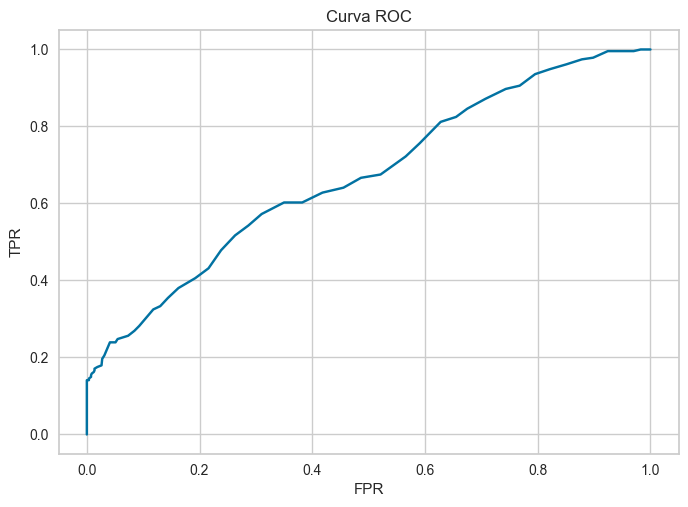

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.show()

## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión